# 1、比赛介绍：  
[Classify Leaves | Kaggle](https://www.kaggle.com/c/classify-leaves)

https://blog.csdn.net/m0_67647321/article/details/135441727

# 2、数据划分：  
该任务是：给出树叶的图片，将给出的树叶分成176类。

In [1]:
#导入一些用到的包
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

接下来我们开始读取数据：读取数据集所在地址、并整理数据集。这里要注意，训练数据和测试数据都放在image文件夹下，我们需要通过train.csv和test.csv中的图片地址来将他们划分开。

>整理数据集思路很简单：将训练数据集和测试数据集划分开，然后将训练数据集中每一个类建立一个文件夹，并把标签对应的图片复制一份到里面。（这里我们用到了验证数据集，和训练数据集操作是一样的）

In [2]:
# import os
# import shutil
# import math
# import collections
# import pandas as pd

def read_csv_labels(fname):
    """读取 `fname` 文件，返回一个标签字典。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]  # 读取文件内容，去掉第一行
    tokens = [l.rstrip().split(',') for l in lines]  # 去除每行末尾的空白字符，并按逗号分割
    return dict(((name, label) for name, label in tokens))  # 返回字典，key是图片名，value是标签

def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)  # 如果目标目录不存在，则创建
    shutil.copy(filename, target_dir)  # 复制文件到目标目录

def reorg_train_valid(data_dir, labels, valid_ratio):
    """重新组织训练集和验证集。"""
    n = collections.Counter(labels.values()).most_common()[-1][1]  # 获取数量最少的类别对应的数量
    n_valid_per_label = max(1, math.floor(n * valid_ratio))  # 计算每个类别的验证集数量
    label_count = {}
    for train_file in labels:  # 遍历训练集文件名
        label = labels[train_file]  # 获取文件对应的标签
        fname = os.path.join(data_dir, train_file)  # 获取文件的完整路径
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))  # 复制文件到训练集目录
        if label not in label_count or label_count[label] < n_valid_per_label:  # 如果该标签的验证集数量未达到上限
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))  # 复制文件到验证集目录
            label_count[label] = label_count.get(label, 0) + 1  # 更新该标签的验证集数量
        else:  # 否则将文件复制到训练集目录
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label  # 返回每个类别的验证集数量

def reorg_test(data_dir):
    """重新组织测试集。"""
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'))  # 读取测试集文件
    for test_file in test['image']:  # 遍历测试集文件名
        copyfile(os.path.join(data_dir, test_file),  # 复制文件到测试集目录
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

def reorg_leave_data(data_dir, valid_ratio):
    """重新组织数据集。"""
    labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))  # 读取训练集标签
    reorg_train_valid(data_dir, labels, valid_ratio)  # 重新组织训练集和验证集
    reorg_test(data_dir)  # 重新组织测试集

batch_size = 128
valid_ratio = 0.1  # 验证集占总数据的比例
data_dir = './01_data/classify-leaves'  # 数据目录路径
if not os.path.exists(os.path.join(data_dir, "train_valid_test")):  # 判断是否已经制作好了数据集
    print("start create dataset")
    reorg_leave_data(data_dir, valid_ratio)  # 调用函数重新组织数据集
else:
    print("Already exists!")
print('dataset created finish')

Already exists!
dataset created finish


# 3、数据增广：  
接下来对图像进行变换，也就是数据增广： 这里需要说下，图像增广，这里并没有把每张图片变成多张，保存下来。而是每次读入的时候，随机的变换成一张，然后送入模型。从整个模型运行的角度看，实际上就是将数据集变大了，因为每次送入的图片大概率是不一样的（随机变换的）

In [3]:
import torchvision.transforms as transforms

# 定义训练集的图像转换操作
transform_train = transforms.Compose([
    # RandomResizedCrop随机裁剪图像到指定大小，224x224
    # scale参数定义了裁剪区域相对于原图的比例范围
    # ratio参数定义了裁剪区域的宽高比范围
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    # RandomHorizontalFlip随机水平翻转图像
    transforms.RandomHorizontalFlip(),
    # ColorJitter随机改变图像的亮度、对比度和饱和度
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # ToTensor将PIL图像或Numpy ndarray转换为Tensor
    transforms.ToTensor(),
    # Normalize对图像的每个通道进行标准化，使用ImageNet的均值和方差
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 定义测试集的图像转换操作
transform_test = transforms.Compose([
    # Resize将图像大小调整为256x256
    transforms.Resize(256),
    # CenterCrop从图像中心裁剪出224x224的区域
    transforms.CenterCrop(224),
    # ToTensor将PIL图像或Numpy ndarray转换为Tensor
    transforms.ToTensor(),
    # Normalize对图像的每个通道进行标准化，使用与训练集相同的均值和方差
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 解释：
# 1. RandomResizedCrop：随机裁剪图像到一个指定的大小，这有助于模型学习图像的不同部分，提高泛化能力。
# 2. RandomHorizontalFlip：随机水平翻转图像，这同样增加了数据的多样性。
# 3. ColorJitter：随机改变图像的亮度、对比度和饱和度，这有助于模型对这些视觉属性的变化更加鲁棒。
# 4. ToTensor：将图像转换为PyTorch张量，因为PyTorch模型通常接受张量作为输入。
# 5. Normalize：标准化图像的像素值，使其具有均值为0，方差为1的分布。这通常使用ImageNet数据集的均值和方差来完成。

>为什么一些深度学习的图像预处理使用mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]来正则化？
>这是因为使用了使用ImageNet的均值和标准差。使用Imagenet的均值和标准差是一种常见的做法。它们是根据数百万张图像计算得出的。如果要在自己的数据集上从头开始训练，则可以计算新的均值和标准差。否则，建议使用Imagenet预设模型及其平均值和标准差

# 4、读取数据：   
我们前面把数据集划分成训练集、验证集和测试集，并每一个类建立了一个文件夹。接下来我们使用 torchvision 的ImageFolder方法，将训练集、验证集和测试集读取进来。

In [4]:
import torchvision.datasets as datasets

data_dir = './01_data/classify-leaves'  # 数据目录路径

# 使用ImageFolder加载训练集和交叉验证集
train_ds, train_valid_ds = [
    datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']
]

# 使用ImageFolder加载验证集和测试集
valid_ds, test_ds = [
    datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']
]

batch_size = 128  # 定义批量大小

# 使用DataLoader将数据集封装，便于批量处理
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)
]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

# 解释：
# 1. ImageFolder：PyTorch提供的一个数据集类，它会自动将文件夹中的图像按类别组织，并应用指定的转换操作。
# 2. transform_train：定义了训练集图像的转换操作，包括随机裁剪、水平翻转、颜色抖动、转换为张量和标准化。
# 3. transform_test：定义了测试集图像的转换操作，包括调整大小、中心裁剪、转换为张量和标准化。
# 4. DataLoader：用于封装数据集，提供批量处理功能。它允许你指定批量大小、是否打乱数据顺序（shuffle）、是否丢弃最后一个不完整的批次（drop_last）。
# 5. shuffle=True：在训练时打乱数据顺序，有助于模型学习。
# 6. drop_last=True：丢弃最后一个不完整的批次，确保每个批次大小一致。
# 7. drop_last=False：在测试时不丢弃最后一个不完整的批次，以便评估所有数据。

# 5、模型构造：  
为了练习微调（迁移学习的一种）的做法，选用了resnet50预训练模型，作为这次比赛的模型。这么做也有点道理，因为resnet系列的预训练模型都是在ImageNet数据集上训练的，而ImageNet数据集，我们都知道100万的图片，分类为1000类，有树叶的分类，因此，可以使用迁移学习的方法做。可能不用微调，直接把resnet50重新训练一遍，应该效果会更好吧。但重在实践吧（doge

In [5]:
# def get_net(devices):
#     finetune_net = nn.Sequential()
#     # finetune_net.features = torchvision.models.resnet50(pretrained=True) # 使用了resnet50的预训练模型
#     finetune_net.output_new = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), # 在后面输出层中，又增加了几层，目的是维度降到类别数
#                                             nn.Linear(512, 256), nn.ReLU(),
#                                             nn.Linear(256, 176)) # 树叶分类有176类
#     finetune_net = finetune_net.to(devices[0]) # 将模型送入gpu
#     for param in finetune_net.features.parameters(): # 固定住预训练模型中的参数，只调节我们新加的几个层的参数
#         param.requires_grad = False
#     return finetune_net

In [10]:
# 微调 ResNet18
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet18(pretrained=True) # 使用了resnet18的预训练模型
    # finetune_net.features = torchvision.models.resnet50(pretrained=True) # 使用了resnet50的预训练模型
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), # 在后面输出层中，又增加了几层，目的是维度降到类别数
                                            nn.Linear(512, 256), nn.ReLU(),
                                            nn.Linear(256, 176)) # 树叶分类有176类
    finetune_net = finetune_net.to(devices[0]) # 将模型送入gpu
    for param in finetune_net.features.parameters(): # 固定住预训练模型中的参数，只调节我们新加的几个层的参数
        param.requires_grad = False
    return finetune_net

In [7]:
# # import torch
# import torch.nn as nn
# import torchvision.models as models

# def get_net(devices):
#     # 初始化一个空的Sequential模型，用于后续添加层
#     finetune_net = nn.Sequential()
    
#     # 使用预训练的ResNet-50模型作为特征提取器
#     # pretrained=True表示下载并使用在ImageNet数据集上预训练的权重
#     finetune_net.features = models.resnet50(pretrained=True)
    
#     # 在预训练模型的基础上添加新的输出层
#     # 由于ResNet-50的输出维度是1000，我们添加了新的全连接层来降低维度
#     # 并最终适配到我们的分类任务（假设有176个类别）
#     finetune_net.output_new = nn.Sequential(
#         nn.Linear(1000, 512),  # 从1000维降至512维
#         nn.ReLU(),              # 激活函数
#         nn.Linear(512, 256),    # 从512维降至256维
#         nn.ReLU(),              # 激活函数
#         nn.Linear(256, 176)     # 最终降至176维，对应176个类别
#     )
    
#     # 将模型移动到指定的设备上，例如GPU
#     finetune_net = finetune_net.to(devices[0])
    
#     # 遍历预训练模型中的参数，设置requires_grad=False
#     # 这意味着在训练过程中，这些参数的梯度不会更新，即参数值保持不变
#     for param in finetune_net.features.parameters():
#         param.requires_grad = False
    
#     # 返回微调后的模型
#     return finetune_net

# # 解释：
# # 1. `nn.Sequential()`：创建一个有序的容器，可以容纳多个层。
# # 2. `models.resnet50(pretrained=True)`：加载预训练的ResNet-50模型。
# # 3. `nn.Linear()`：定义全连接层，用于降低特征维度。
# # 4. `nn.ReLU()`：应用ReLU激活函数，增加非线性。
# # 5. `to(devices[0])`：将模型移动到指定的设备上，通常是GPU，以加速计算。
# # 6. `param.requires_grad = False`：设置参数的requires_grad属性，固定预训练模型的参数，不参与梯度更新。

# 6、计算损失：

In [8]:
import torch
import torch.nn as nn

# 初始化交叉熵损失函数，不包含softmax操作
# reduction='none'表示返回每个样本的损失，而不是默认的计算所有样本的平均损失
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    """
    评估模型在给定数据集上的损失。
    
    参数:
        data_iter (iterable): 一个迭代器，生成(batch_features, batch_labels)。
        net (torch.nn.Module): 要评估的神经网络模型。
        devices (list): 模型运行的设备列表。
        
    返回:
        float: 所有样本损失的平均值。
    """
    l_sum, n = 0.0, 0  # 初始化损失总和和样本总数
    with torch.no_grad():  # 不计算梯度，减少内存消耗
        for features, labels in data_iter:
            # 将数据移动到指定的设备上，例如GPU
            features, labels = features.to(devices[0]), labels.to(devices[0])
            # 模型前向传播，输出预测结果
            outputs = net(features)
            # 计算损失，outputs和labels的维度需要匹配
            l = loss(outputs, labels)
            # 累加损失总和，并计算样本总数
            l_sum += l.sum()
            n += labels.numel()  # numel()返回张量中元素的总数

    # 计算并返回平均损失
    return l_sum / n

# 解释：
# 1. `nn.CrossEntropyLoss(reduction='none')`: 创建一个交叉熵损失函数，不自动应用softmax。
# 2. `evaluate_loss`: 定义了一个函数，用于在给定数据集上评估模型的损失。
# 3. `torch.no_grad()`: 用于在评估过程中禁用梯度计算，减少内存消耗。
# 4. `features.to(devices[0])` 和 `labels.to(devices[0])`: 将数据移动到指定的设备上，例如GPU。
# 5. `net(features)`: 模型前向传播，输出预测结果。
# 6. `loss(outputs, labels)`: 计算预测结果和真实标签之间的损失。
# 7. `l_sum += l.sum()`: 累加每个批次的损失总和。
# 8. `n += labels.numel()`: 更新样本总数，numel()返回张量中元素的总数。
# 9. `return l_sum / n`: 返回所有样本损失的平均值。

# 7、模型训练：

train loss 1.750, valid loss 1.770
1176.6 examples/sec on [device(type='cuda', index=0)]


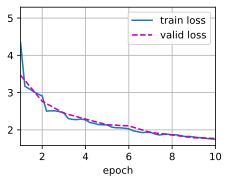

In [11]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    """
    wd：权衰量,用于防止过拟合
    lr_period：每隔几个epoch降低学习率
    lr_decay：降低学习率的比例
    """
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 使用多gpu
    trainer = torch.optim.SGD(  # 随机梯度下降
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)  # 使用学习率衰减
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)  # 画图
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])  # 特征和标签都放到gpu
            trainer.zero_grad()  # 梯度清零
            output = net(features)  # 得出预测结果
            l = loss(output, labels).sum()
            l.backward()  # 反向传播，求梯度
            trainer.step()  # 更新参数
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
                # 打印train_loss,test_loss,train_acc,test_acc
                print(f'epoch {epoch + 1}, step {i + 1}, loss {metric[0] / metric[1]:.3f}')
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:  # 计算验证集的loss
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.cpu().detach()))
        scheduler.step()  # 一个epoch完了，衰减学习率
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
 
# 调用上面的函数：训练和验证模型
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 8、模型推理：

In [ ]:
# devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
# lr_period, lr_decay= 4, 0.9
 
# net, preds = get_net(devices), []
# train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
 
# test = pd.read_csv(os.path.join(data_dir, 'test.csv')) # 存放 测试集图片地址 的文件
# for X, _ in test_iter:
#     y_hat = net(X.to(devices[0]))
#     preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
# sorted_ids = test['image'] # 对应的id
# df = pd.DataFrame({'image': sorted_ids, 'label': preds}) # 转换成pandas的DF格式
 
# # .apply()函数：遍历DataFrame的元素（一行数据或者一列数据），默认列遍历
# # ImageFolder返回对象的.classes属性：用一个 list 保存类别名称
# # 这个的作用是：模型预测出来是概率最大的那个数的下标，在保存文件时，需要把数字类别转换为字符串类别，
# # train_valid_ds.classes就是获取字符串类别名（返回的是一个列表），然后使用apply一行一行读取出来，把数字类别转换为字符串类别
# df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x]) 
# df.to_csv(r'..\data\classify-leaves\submission.csv', index=False)

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torchvision.transforms as transforms
# import pandas as pd
# from torch.utils.data import DataLoader, Dataset
# import os

# 尝试获取所有可用的GPU设备
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
# 设置学习率衰减周期和衰减比率
lr_period, lr_decay = 4, 0.9

# 获取预训练模型并将其移动到GPU上
net = get_net(devices)
# 初始化预测结果列表
preds = []

# 训练模型
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 读取测试集的CSV文件
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

# 初始化测试数据的迭代器
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

# 对测试集进行预测
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

# 获取测试集图像的ID
sorted_ids = test['image']

# 将预测结果和图像ID组合成DataFrame
df = pd.DataFrame({'image': sorted_ids, 'label': preds})

# 将数字类别转换为字符串类别
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])

# 保存预测结果到CSV文件
df.to_csv(r'./01_data/classify-leaves/submission.csv', index=False)
# 解释：
# 1. `d2l.try_all_gpus()`: 尝试获取所有可用的GPU设备。
# 2. `get_net(devices)`: 获取预训练模型并将其移动到GPU上。
# 3. `train`: 训练模型。
# 4. `pd.read_csv()`: 读取测试集的CSV文件。
# 5. `torch.utils.data.DataLoader()`: 初始化测试数据的迭代器。
# 6. `net(X.to(devices[0]))`: 使用模型对测试数据进行预测。
# 7. `preds.extend(...)`: 将预测结果添加到列表中。
# 8. `df = pd.DataFrame(...)`: 将图像ID和预测结果组合成DataFrame。
# 9. `df['label'].apply(...)`: 将数字类别转换为字符串类别。
# 10. `df.to_csv(...)`: 将预测结果保存到CSV文件中。

In [13]:
df.to_csv(r'./01_data/classify-leaves/submission.csv', index=False)
# ./01_data/classify-leaves/train.csv